# This File

* Pull runs from wandb to visualize data from
* Load data from tensorboard runs (currently functions to do this are in read_experiments.ipynb)
* Create plots used in progress report so far

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import wandb
import scipy.interpolate


entity = 'andyliu'
projects = ['GridNav_Reward_Shaping', 'GridNav_Visible_Platform_Colored_Walls', 
            'GridNav_Invisible_Reward_Colors', 'GridNav_Invisible_Reward_Poster']

api = wandb.Api()


font = {'size' : 20,
       'family': 'serif',
       'sans-serif': ['Helvetica']}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

save_folder = 'plots/proof_of_concept/'





def get_runs(project_idx=0):
    '''
    Get iterrable of runs from the project
    Idxes fixed from projects list at top of jupyter notebook
    '''
    return api.runs(path=entity +'/' + projects[project_idx])


def get_metric(run, metrics=[], smoothing=0.01):
    '''
    Pull metrics from wandb run
    metrics: list of names of metrics to pull
    smoothing: whether to perform exponential smoothing on data
        False: no smoothing applied
        <val from 0-1>: smoothing parameter used
    '''
    data = run.history()
    df = data[['_step', 'global_step'] + metrics]
    df = df.dropna()
    if smoothing is not False:
        for metric in metrics:
            df.loc[:, metric+'_ewm'] = df[metric].ewm(alpha=smoothing).mean()
    return df



def plot_cloud_from_dict(datas, labels=None, data_col='charts/episodic_length_ewm',
                        ax=None):
    '''
    Plot a cloud of trajectories build from dataframes from wandb into a dictionary
    The structure of the datas dictionary should be
    datas = {
        key1: [df1, df2, df3,...],
        key2: [df1, df2, df3,...],
        ...
    }
    Each df should have the 'global_step' data column in it to plot using (this is x-axis)
    data_col: column name in the df that contains the y-axis plot data
    
    '''
    if ax is None:
        ax = plt
        ax.figure(figsize=(10, 10))
    
    for key in datas.keys():
        first_xs = []
        last_xs = []
        inters = []
        
        for j in range(len(datas[key])):
            df = datas[key][j]
            
            first_xs.append(df.iloc[0]['global_step'])
            last_xs.append(df.iloc[-1]['global_step'])

            inter = scipy.interpolate.interp1d(df['global_step'], df[data_col])
            inters.append(inter)
            
        min_x = np.max(first_xs)
        max_x = np.min(last_xs)
        xs = np.arange(min_x, max_x, 200)
        ys = np.zeros((len(datas[key]), len(xs)))

        for j in range(len(datas[key])):
            ys[j] = inters[j](xs)
                       
        ax.fill_between(xs, ys.min(axis=0), ys.max(axis=0), alpha=0.1)
        if labels is not None:
            ax.plot(xs, ys.mean(axis=0), label=labels[key])
        else:
            ax.plot(xs, ys.mean(axis=0))
            
    if labels is not None:
        ax.legend()
        

    

# Checking episodic returns for different reward shaping params

Visible platform, use 4 different reward shaping modes - each experiment contains 10 trials
* Reward only on goal reached, 1 point rewarded
* Reward proportional to how close agent is to goal (closeness) with max of 0.01 rewarded, and 1 point on reaching goal
* Reward closeness when goal is in sight, and on goal reached
* Reward closeness once goal has been seen at least once, and on goal reached

Learning seems to be possible without any additional reward shaping, but any sort of reward shaping improves learning process. 

In future case, if training with reward shaping, we assume to use only the first method (closeness rewarded no matter if goal is in sight)

In [5]:
#collect data from wandb
runs = get_runs(0)
shapes = [[] for i in range(4)]

for i, run in enumerate(runs):
    if run.state == 'finished':
        shape = run.config['env_kwargs']['reward_shaping']
        metrics = run.history()
        df = metrics[['_step', 'global_step', 'charts/episodic_length']]
        df = df.dropna()
        df.loc[:, 'ewm'] = df['charts/episodic_length'].ewm(alpha=0.01).mean()
        shapes[shape].append(df)


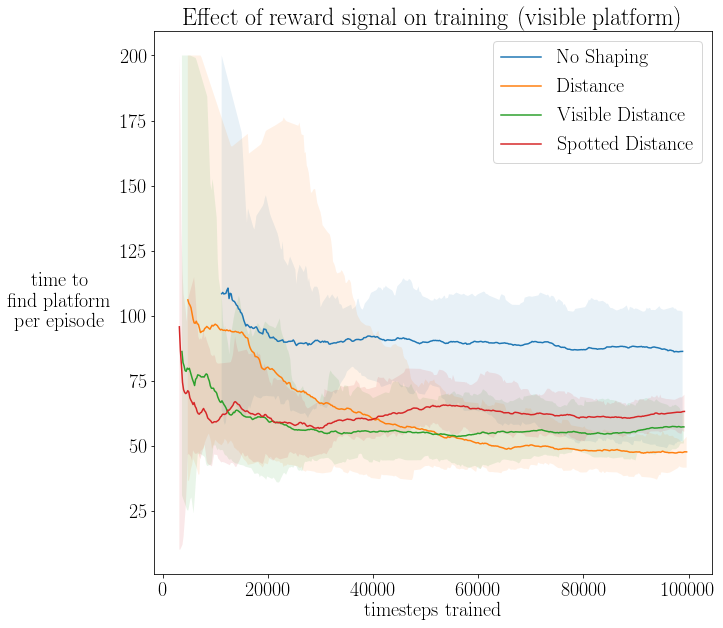

In [9]:
# fig, ax = plt.subplots(2, 2, figsize=(12, 12))
plt.figure(figsize=(10, 10))

labels = ['No Shaping', 'Distance', 'Visible Distance', 'Spotted Distance']
for i in range(4):
    # plot_x, plot_y = 
    first_xs = []
    last_xs = []
    inters = []
    for j in range(len(shapes[i])):
        df = shapes[i][j]

        first_xs.append(df.iloc[0]['global_step'])
        last_xs.append(df.iloc[-1]['global_step'])

        inter = scipy.interpolate.interp1d(df['global_step'], df['ewm'])
        inters.append(inter)

        # plt.plot(df['global_step'], df['ewm'])

    min_x = np.max(first_xs)
    max_x = np.min(last_xs)
    xs = np.arange(min_x, max_x, 200)
    ys = np.zeros((len(shapes[i]), len(xs)))

    for j in range(len(shapes[i])):
        ys[j] = inters[j](xs)

    plt.fill_between(xs, ys.min(axis=0), ys.max(axis=0), alpha=0.1)
    plt.plot(xs, ys.mean(axis=0), label=labels[i])
    
plt.legend()
plt.title('Effect of reward signal on training (visible platform)')
plt.ylabel('time to\nfind platform\nper episode', rotation=0, va='center', labelpad=60)
plt.xlabel('timesteps trained')

plt.savefig(save_folder + '1_reward_shaping.png', bbox_inches='tight')

# Wall colors with visible platform

Next check the effect of having different wall colors on finding goal (can adding colors to walls improve navigability of pool?) - each experiment contains 10 trials
* All red
* Red/Green walls symmetrical (red, green, red, green)
* Red/Green walls asymmetrical (red, red, green, green)
* All walls different colors

Here all cases are trained with reward shaping. We find that adding wall colors does not significantly improve navigability based on learning curve (although we might be inclined to test other measures, such as search strategy, for example, may want to test taking platform away entirely)

However, adding 4 wall colors leads to more confounding information to be learned and slows learning. Asymptotically, performance converges between different cases

Note that here, we are using an LSTM network. This network structure theoretically allows the agent to learn latent world information (such as where the agent has navigated and visited), thus it would not necessarily need Markovian conditions for navigation

In [122]:
colors = [1, 2, 2.5, 4]
datas = [[] for i in range(len(colors))]

runs = get_runs(1)
for i, run in enumerate(runs):
    # print(run.summary['global_step'])
    if run.state == 'finished' and run.summary['global_step'] > 200000:
        color = run.config['env_kwargs']['wall_colors']
        metrics = run.history()
        df = metrics[['_step', 'global_step', 'charts/episodic_length']]
        df = df.dropna()
        df.loc[:, 'ewm'] = df['charts/episodic_length'].ewm(alpha=0.01).mean()
        datas[colors.index(color)].append(df)
        



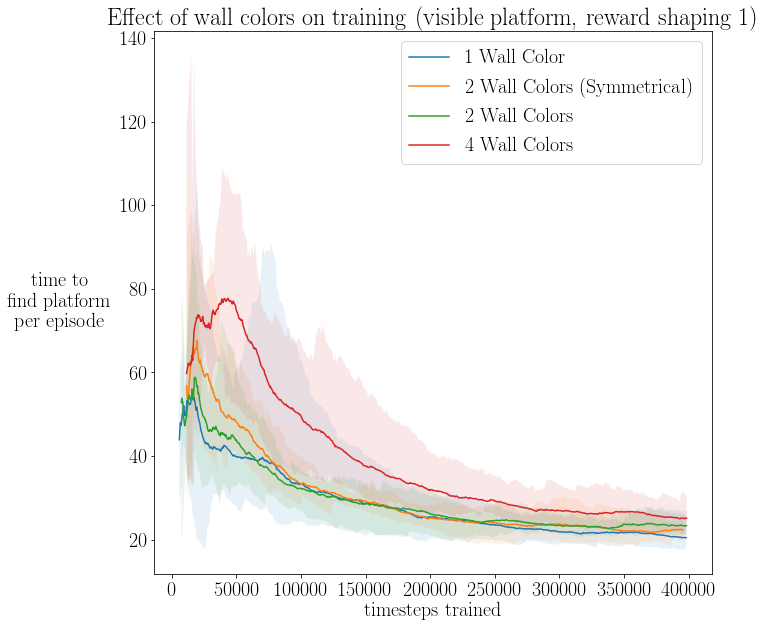

In [123]:
# fig, ax = plt.subplots(2, 2, figsize=(12, 12))
plt.figure(figsize=(10, 10))

labels = ['1 Wall Color', '2 Wall Colors (Symmetrical)', '2 Wall Colors', '4 Wall Colors']
for i in range(4):
    # plot_x, plot_y = 
    first_xs = []
    last_xs = []
    inters = []
    for j in range(len(datas[i])):
        df = datas[i][j]

        first_xs.append(df.iloc[0]['global_step'])
        last_xs.append(df.iloc[-1]['global_step'])

        inter = scipy.interpolate.interp1d(df['global_step'], df['ewm'])
        inters.append(inter)

        # plt.plot(df['global_step'], df['ewm'])

    min_x = np.max(first_xs)
    max_x = np.min(last_xs)
    xs = np.arange(min_x, max_x, 200)
    ys = np.zeros((len(datas[i]), len(xs)))

    for j in range(len(datas[i])):
        ys[j] = inters[j](xs)

    plt.fill_between(xs, ys.min(axis=0), ys.max(axis=0), alpha=0.1)
    plt.plot(xs, ys.mean(axis=0), label=labels[i])
    

    
plt.legend()
plt.title('Effect of wall colors on training (visible platform, reward shaping 1)')
plt.ylabel('time to\nfind platform\nper episode', rotation=0, va='center', labelpad=60)
plt.xlabel('timesteps trained')

plt.savefig(save_folder + '2_visible_platform_wall_colors', bbox_inches='tight')

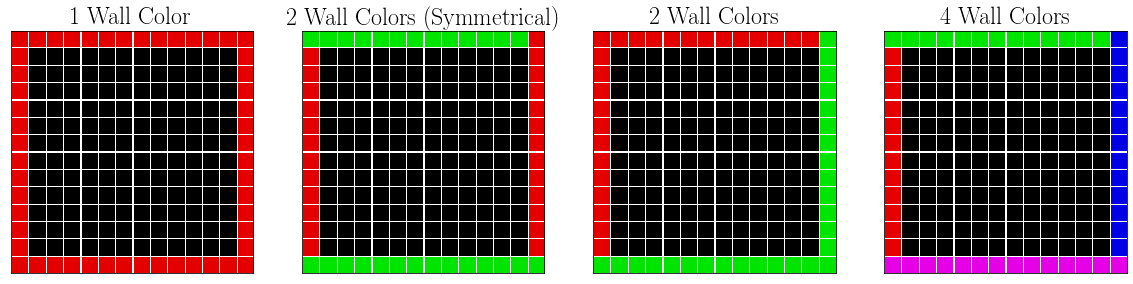

In [121]:
def render(self, mode='human', ax=None):
    if ax is None:
        ax = plt
        ax.figure(figsize=(8, 8))
    window_size = [(self.world_size[0]) * 16, (self.world_size[1]) * 16]

    img = np.zeros(window_size + [3])

    #draw grid
    img[np.arange(0, window_size[0], 16), :, :] = 1
    img[:, np.arange(0, window_size[1], 16), :] = 1

    def color_block(x, y, rgb, img):
        img[y*16+1:(y+1)*16, x*16+1:(x+1)*16] = rgb
        return img

    #draw solid objects
    for i in range(self.world_size[0]):
        for j in range(self.world_size[1]):
            if self.visible[i, j] != 0:
                # print(i)
                # img[i*16+1:(i+1)*16, j*16+1:(j+1)*16] = self.idx_to_rgb[self.visible[i, j]]
                img = color_block(j, i, self.idx_to_rgb[self.visible[i, j]], img)
            elif self.objects[i, j] != 0:
                #draw invisible objects for viewer
                img = color_block(j, i, [0.6, 0.6, 0.6], img)

    if mode == 'rgb_array':
        # return img.astype('uint8') * 255
        return (img * 255).astype('uint8')
    elif mode == 'human':
        ax.imshow(img)


import gym
import gym_nav

colors = [1, 2, 2.5, 4]
label_list = ['1 Wall Color', '2 Wall Colors (Symmetrical)', '2 Wall Colors', '4 Wall Colors']


fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for x, color in enumerate(colors):
    env = gym.make('Gridworld-v0', num_obstacles=0, world_size=14, wall_colors=color)
    env.render = render
    for i in range(1, 13):
        for j in range(1, 13):
            env.visible[i, j] = 0
            env.objects[i, j] = 0
    env.agent[0] = [1, 1]
    env.agent[1] = 0
    env.render(env, ax=ax[x])
    ax[x].set_xticks([])
    ax[x].set_yticks([])
    ax[x].set_title(label_list[x])
plt.savefig(save_folder + '2a_wall_colors.png', bbox_inches='tight')

# Invisible goal with different wall colors

Next, we test making the platform invisible, and seeing whether wall colors now improve navigability or not

**Note here that the platform always has the same position, so the challenge is to determine where you are in relation to the platform**

Same wall colors as the previous experiment. Here we see a strong heterogeneity with performance depending on wall colors

For the 2 wall color and 4 wall color scenarios, there is asymmetry that can be relied on for navigation. For 1 wall color and 2 symmetrical wall colors, global information that is provided by the walls decreases.

Something suspicious happens with 1 wall color however - the trajectory cloud is much wider


## Shaped reward

This gives a slightly clearer picture of the effect of wall colors on training, decreasing how much the randomness of seeds (i.e., on whether or not the agent randomly stumbles on goal) affects the training trajectory

In [74]:
runs = get_runs(2)

colors = [1, 2, 2.5, 4]
label_list = ['1 Wall Color', '2 Wall Colors (Symmetrical)', '2 Wall Colors', '4 Wall Colors']
datas = {color: [] for color in colors}
labels = {colors[i]: label_list[i] for i in range(len(colors))}
for run in runs:
    if run.state == 'finished' and \
        run.config['env_kwargs']['reward_shaping'] == 1 and run.config['seed'] < 3:
        color = run.config['env_kwargs']['wall_colors']
        df = get_metric(run, ['charts/episodic_length'])
        datas[color].append(df)

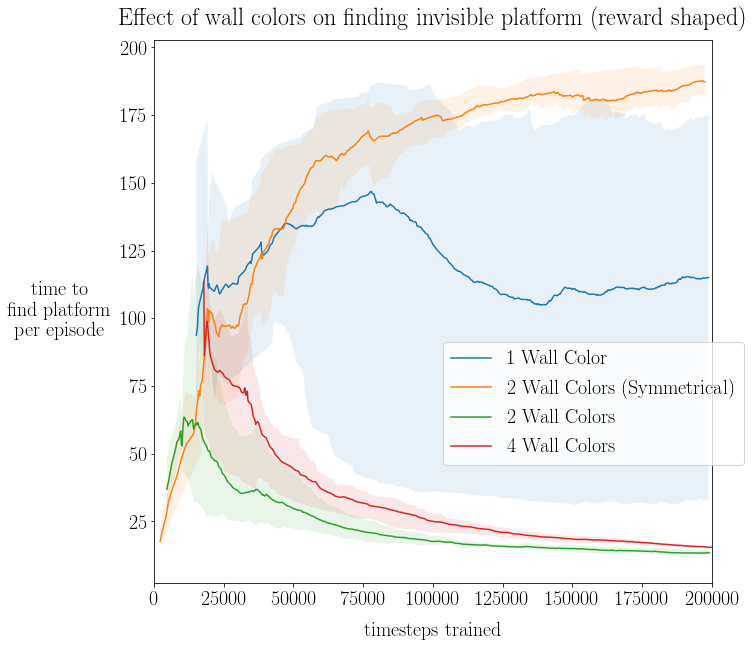

In [75]:
plot_cloud_from_dict(datas, labels)
plt.ylabel('time to\nfind platform\nper episode', rotation=0, va='center', labelpad=60)
plt.xlabel('timesteps trained', labelpad=15)
plt.xlim([0, 200000])
plt.title('Effect of wall colors on finding invisible platform (reward shaped)', pad=15)
plt.legend(bbox_to_anchor=(0.5, 0.2, 0, 0))

plt.savefig(save_folder + '3_1_invisible_wall_colors_shaped_reward', bbox_inches='tight')

## Non-shaped reward

This is a good visual indication of randomness effect on training

In [167]:
runs = get_runs(2)

colors = [1, 2, 2.5, 4]
label_list = ['1 Wall Color', '2 Wall Colors (Symmetrical)', '2 Wall Colors', '4 Wall Colors']
datas = {color: [] for color in colors}
labels = {colors[i]: label_list[i] for i in range(len(colors))}
for run in runs:
    if run.state == 'finished' and \
        run.config['env_kwargs']['reward_shaping'] == 0 and run.config['seed'] < 3:
        color = run.config['env_kwargs']['wall_colors']
        df = get_metric(run, ['charts/episodic_length'])
        datas[color].append(df)

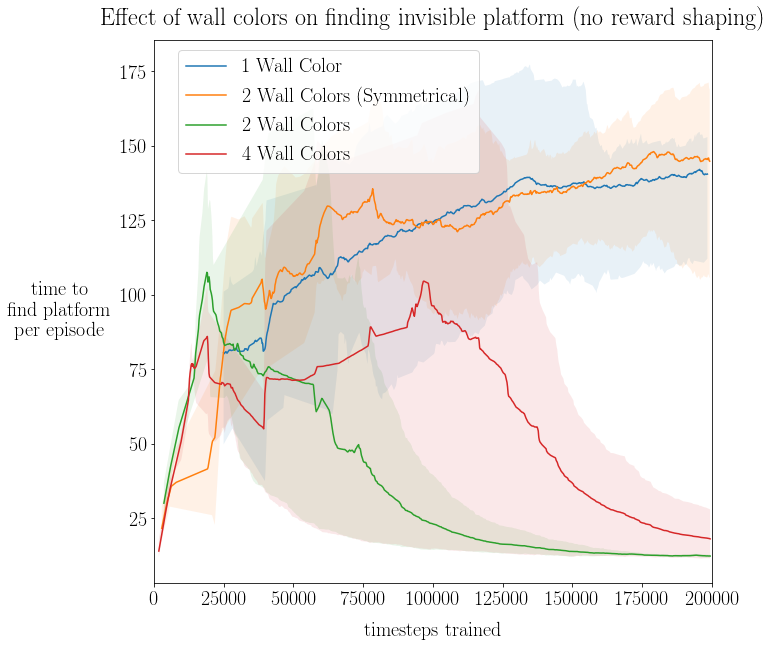

In [168]:
plot_cloud_from_dict(datas, labels)
plt.ylabel('time to\nfind platform\nper episode', rotation=0, va='center', labelpad=60)
plt.xlabel('timesteps trained', labelpad=15)
plt.xlim([0, 200000])
plt.title('Effect of wall colors on finding invisible platform (no reward shaping)', pad=15)
plt.legend(bbox_to_anchor=(0.6, 1, 0, 0))

plt.savefig(save_folder + '3_2_invisible_wall_colors_nonshaped_reward', bbox_inches='tight')

## Individual Trials 1 Wall Color

Here it is clear that there is some learning that is possible (especially with reward shaping). Here, each trajectory represents a different random instantiation of the training regiment

In [131]:
runs = get_runs(2)

shapes = [0, 1]
datas = {shape: [] for shape in shapes}
for run in runs:
    if run.state == 'finished' and run.config['env_kwargs']['wall_colors'] == 1 and \
        run.summary['global_step'] > 300000 :
        shape = run.config['env_kwargs']['reward_shaping']
        df = get_metric(run, ['charts/episodic_length'])
        datas[shape].append(df)

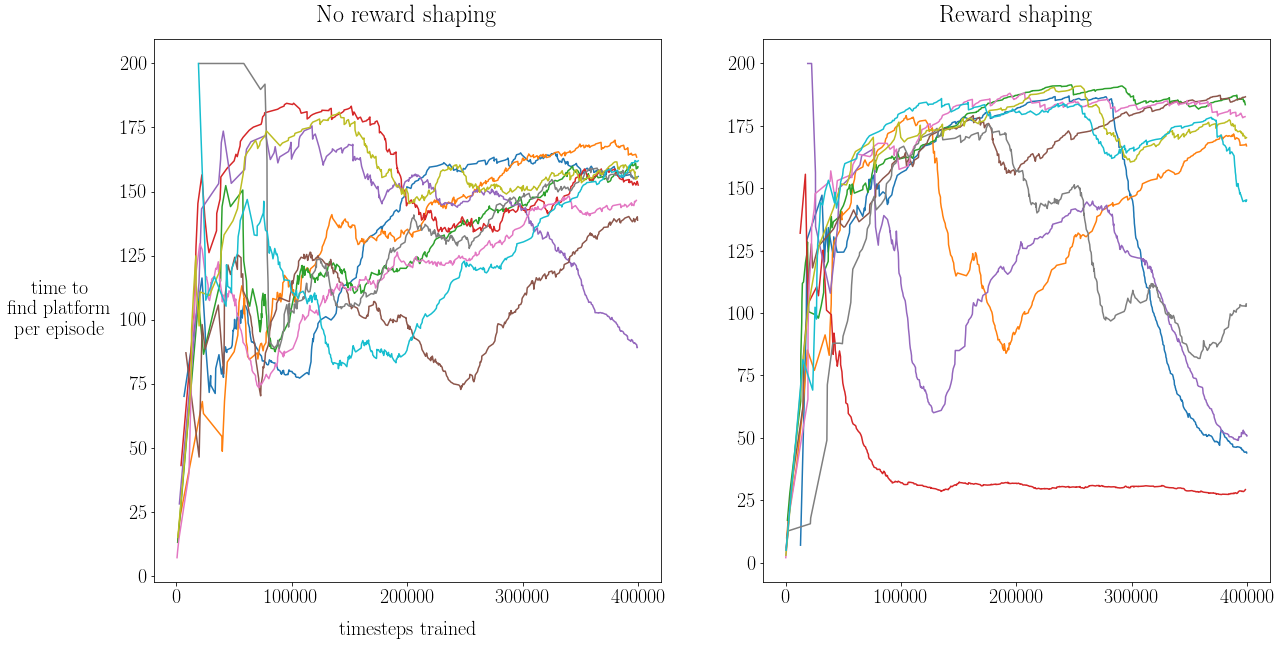

In [135]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))



for x, shape in enumerate(shapes):
    for i in range(len(datas[shape])):
        df = datas[shape][i]
        ax[x].plot(df['global_step'], df['charts/episodic_length_ewm'])
        

ax[0].set_ylabel('time to\nfind platform\nper episode', labelpad=60, rotation=0, va='center')
ax[0].set_xlabel('timesteps trained', labelpad=15)
ax[0].set_title('No reward shaping', pad=15)
ax[1].set_title('Reward shaping', pad=15)

plt.savefig(save_folder + '3_3_single_wall_color_individual_trials.png', bbox_inches='tight')

# Poster Examples

Here we simulate "hanging posters" on the wall to provide the asymmetry / global cue to navigate by

There is a close poster case vs a far poster case

Here clearly, the close poster does indeed make navigation easier. What is slightly harder to understand is why remove reward shaping seems to significantly improve training in the close poster case. This may be because the reward signal is slightly confounding, where you need to turn to look at and use the poster for navigation, but the reward shaping subgoal incentivizes you to move forward primarily rather than turn.

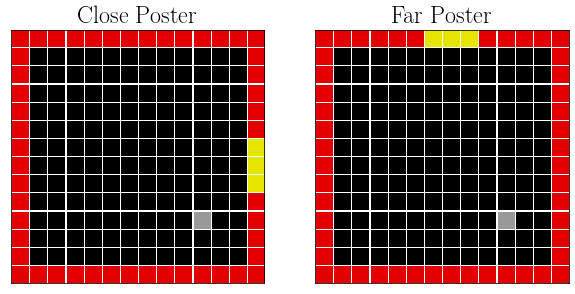

In [154]:
def render(self, mode='human', ax=None):
    if ax is None:
        ax = plt
        ax.figure(figsize=(8, 8))
    window_size = [(self.world_size[0]) * 16, (self.world_size[1]) * 16]

    img = np.zeros(window_size + [3])

    #draw grid
    img[np.arange(0, window_size[0], 16), :, :] = 1
    img[:, np.arange(0, window_size[1], 16), :] = 1

    def color_block(x, y, rgb, img):
        img[y*16+1:(y+1)*16, x*16+1:(x+1)*16] = rgb
        return img

    #draw solid objects
    for i in range(self.world_size[0]):
        for j in range(self.world_size[1]):
            if self.visible[i, j] != 0:
                # print(i)
                # img[i*16+1:(i+1)*16, j*16+1:(j+1)*16] = self.idx_to_rgb[self.visible[i, j]]
                img = color_block(j, i, self.idx_to_rgb[self.visible[i, j]], img)
            elif self.objects[i, j] != 0:
                #draw invisible objects for viewer
                img = color_block(j, i, [0.6, 0.6, 0.6], img)

    if mode == 'rgb_array':
        # return img.astype('uint8') * 255
        return (img * 255).astype('uint8')
    elif mode == 'human':
        ax.imshow(img)


import gym
import gym_nav

posters = [0, 1]
label_list = ['Close Poster', 'Far Poster']


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for x, poster in enumerate(posters):
    env = gym.make('Gridworld-v0', num_obstacles=0, world_size=14, wall_colors=1, poster=poster,
                  task_structure=2)
    env.render = render
    env.agent[0] = [1, 1]
    env.agent[1] = 0
    env.render(env, ax=ax[x])
    ax[x].set_xticks([])
    ax[x].set_yticks([])
    ax[x].set_title(label_list[x])
plt.savefig(save_folder + '4a_posters.png', bbox_inches='tight')

In [159]:
runs = get_runs(3)
posters = [0, 1]
datas0 = {poster: [] for poster in posters} #not shaped
datas1 = {poster: [] for poster in posters} #shaped
labels_list = ['Close Poster', 'Far Poster']
labels = {posters[i]: labels_list[i] for i in range(2)}
for run in runs:
    if run.state == 'finished' and run.config['env_kwargs']['reward_shaping'] == 1: 
        poster = run.config['env_kwargs']['poster']
        df = get_metric(run, ['charts/episodic_length'])
        datas1[poster].append(df)
    elif run.state == 'finished' and run.config['env_kwargs']['reward_shaping'] == 0:
        poster = run.config['env_kwargs']['poster']
        df = get_metric(run, ['charts/episodic_length'])
        datas0[poster].append(df)


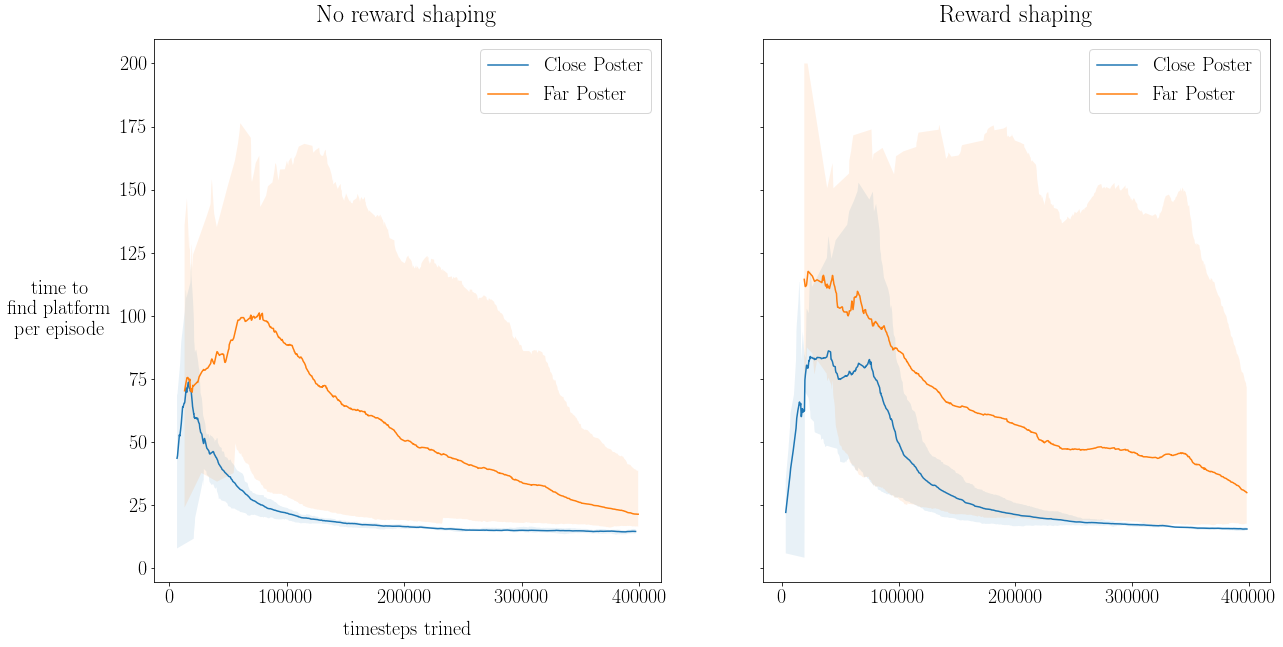

In [166]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
plot_cloud_from_dict(datas0, labels, ax=ax[0])
plot_cloud_from_dict(datas1, labels, ax=ax[1])

ax[0].set_title('No reward shaping', pad=15)
ax[1].set_title('Reward shaping', pad=15)

ax[0].set_ylabel('time to\nfind platform\nper episode', rotation=0, va='center', labelpad=60)
ax[0].set_xlabel('timesteps trined', labelpad=15)

plt.savefig(save_folder + '4_poster_training.png', bbox_inches='tight')